In [16]:
import sys
sys.path.append('../')
import os
from utils.imageprocessing import 
from models.biomed_UNet.predict import predict_img, plot_img_and_mask
import torch
from models.biomed_UNet import model as UNet
from PIL import Image

In [24]:
path = './checkpoints_unet-biomed-b6_2024-05-15_15-30/checkpoint_epoch15.pth'
filename = '../data/2024-04-21-dataset/standard/test/images/tile_tif_23_11.png'

In [12]:
net = UNet(n_channels=3, n_classes=2, bilinear=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device=device)

state_dict = torch.load(path, map_location=device)

mask_values = state_dict.pop('mask_values', [0, 255])
net.load_state_dict(state_dict)

<All keys matched successfully>

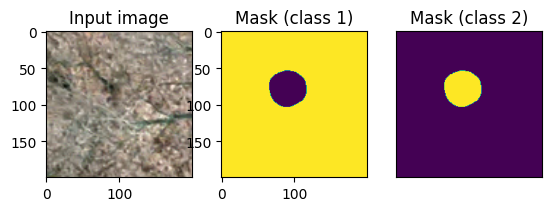

In [30]:
img = Image.open(filename)
mask = predict_img(net=net,
                   full_img=img,
                   scale_factor=1,
                   out_threshold=0.9,
                   device=device)
plot_img_and_mask(img, mask)